##Load data

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [2]:
import os
import glob
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch.utils.data as data

In [3]:
#mapping from igbp to dfc2020 classes
DFC2020_CLASSES = [
    0,  # class 0 unused in both schemes
    1,
    1,
    1,
    1,
    1,
    2,
    2,
    3,  # --> will be masked if no_savanna == True
    3,  # --> will be masked if no_savanna == True
    4,
    5,
    6,  # 12 --> 6
    7,  # 13 --> 7
    6,  # 14 --> 6
    8,
    9,
    10
    ]

In [4]:
# indices of sentinel-2 high-/medium-/low-resolution bands
S2_BANDS_HR = [2, 3, 4, 8]
S2_BANDS_MR = [5, 6, 7, 9, 12, 13]
S2_BANDS_LR = [1, 10, 11]

In [5]:
# util function for reading s2 data
def load_s2(path, use_hr, use_mr, use_lr):
    bands_selected = []
    if use_hr:
        bands_selected = bands_selected + S2_BANDS_HR
    if use_mr:
        bands_selected = bands_selected + S2_BANDS_MR
    if use_lr:
        bands_selected = bands_selected + S2_BANDS_LR
    bands_selected = sorted(bands_selected)
    with rasterio.open(path) as data:
        s2 = data.read(bands_selected)
    s2 = s2.astype(np.float32)
    s2 = np.clip(s2, 0, 10000)
    s2 /= 10000
    s2 = s2.astype(np.float32)
    return s2

In [6]:
# util function for reading s1 data
def load_s1(path):
    with rasterio.open(path) as data:
        s1 = data.read()
    s1 = s1.astype(np.float32)
    s1 = np.nan_to_num(s1)
    s1 = np.clip(s1, -25, 0)
    s1 /= 25
    s1 += 1
    s1 = s1.astype(np.float32)
    return s1

In [7]:
# util function for reading lc data
def load_lc(path, no_savanna=False, igbp=True):

    # load labels
    with rasterio.open(path) as data:
        lc = data.read(1)

    # convert IGBP to dfc2020 classes
    if igbp:
        lc = np.take(DFC2020_CLASSES, lc)
    else:
        lc = lc.astype(np.int64)

    # adjust class scheme to ignore class savanna
    if no_savanna:
        lc[lc == 3] = 0
        lc[lc > 3] -= 1

    # convert to zero-based labels and set ignore mask
    lc -= 1
    lc[lc == -1] = 255
    return lc

In [8]:
# util function for reading data from single sample
def load_sample(sample, use_s1, use_s2hr, use_s2mr, use_s2lr,
                no_savanna=False, igbp=True, unlabeled=False):

    use_s2 = use_s2hr or use_s2mr or use_s2lr

    # load s2 data
    if use_s2:
        img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr)

    # load s1 data
    if use_s1:
        if use_s2:
            img = np.concatenate((img, load_s1(sample["s1"])), axis=0)
        else:
            img = load_s1(sample["s1"])

    # load label
    if unlabeled:
        return {'image': img, 'id': sample["id"]}
    else:
        lc = load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp)
        return {'image': img, 'label': lc, 'id': sample["id"]}

In [9]:
# calculate number of input channels
def get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr):
    n_inputs = 0
    if use_s2hr:
        n_inputs += len(S2_BANDS_HR)
    if use_s2mr:
        n_inputs += len(S2_BANDS_MR)
    if use_s2lr:
        n_inputs += len(S2_BANDS_LR)
    if use_s1:
        n_inputs += 2
    return n_inputs


In [10]:
# select channels for preview images
def get_display_channels(use_s2hr, use_s2mr, use_s2lr):
    if use_s2hr and use_s2lr:
        display_channels = [3, 2, 1]
        brightness_factor = 3
    elif use_s2hr:
        display_channels = [2, 1, 0]
        brightness_factor = 3
    elif not (use_s2hr or use_s2mr or use_s2lr):
        display_channels = 0
        brightness_factor = 1
    else:
        display_channels = 0
        brightness_factor = 3
    return (display_channels, brightness_factor)

In [11]:
class DFC2020(data.Dataset):
    """PyTorch dataset class for the DFC2020 dataset"""

    def __init__(self,
                 path,
                 subset="val",
                 no_savanna=False,
                 use_s2hr=False,
                 use_s2mr=False,
                 use_s2lr=False,
                 use_s1=False):
        """Initialize the dataset"""

        # inizialize
        super(DFC2020, self).__init__()

        # make sure parameters are okay
        if not (use_s2hr or use_s2mr or use_s2lr or use_s1):
            raise ValueError("No input specified, set at least one of "
                             + "use_[s2hr, s2mr, s2lr, s1] to True!")
        self.use_s2hr = use_s2hr
        self.use_s2mr = use_s2mr
        self.use_s2lr = use_s2lr
        self.use_s1 = use_s1
        assert subset in ["val", "test"]
        self.no_savanna = no_savanna

        # provide number of input channels
        self.n_inputs = get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr)

        # provide index of channel(s) suitable for previewing the input
        self.display_channels, self.brightness_factor = get_display_channels(
                                                            use_s2hr,
                                                            use_s2mr,
                                                            use_s2lr)

        # provide number of classes
        if no_savanna:
            self.n_classes = max(DFC2020_CLASSES) - 1
        else:
            self.n_classes = max(DFC2020_CLASSES)

        # make sure parent dir exists
        assert os.path.exists(path)

        # build list of sample paths
        if subset == "val":
            path = os.path.join(path, "ROIs0000_validation", "s2_validation")
        else:
            path = os.path.join(path, "ROIs0000_test", "s2_0")
        s2_locations = glob.glob(os.path.join(path, "*.tif"), recursive=True)
        self.samples = []
        for s2_loc in tqdm(s2_locations, desc="[Load]"):
            s1_loc = s2_loc.replace("_s2_", "_s1_").replace("s2_", "s1_")
            lc_loc = s2_loc.replace("_dfc_", "_lc_").replace("s2_", "dfc_")
            self.samples.append({"lc": lc_loc, "s1": s1_loc, "s2": s2_loc,
                                 "id": os.path.basename(s2_loc)})

        # sort list of samples
        self.samples = sorted(self.samples, key=lambda i: i['id'])

        print("loaded", len(self.samples),
              "samples from the dfc2020 subset", subset)

    def __getitem__(self, index):
        """Get a single example from the dataset"""

        # get and load sample from index file
        sample = self.samples[index]
        return load_sample(sample, self.use_s1, self.use_s2hr, self.use_s2mr,
                           self.use_s2lr, no_savanna=self.no_savanna,
                           igbp=False)

    def __len__(self):
        """Get number of samples in the dataset"""
        return len(self.samples)


In [12]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/dfc_testdata'

In [14]:
ds = DFC2020(data_dir, subset="val", use_s1=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)

[Load]: 100%|██████████| 3/3 [00:00<00:00, 6223.00it/s]

loaded 3 samples from the dfc2020 subset val


Visualize data

In [15]:
s = ds.__getitem__(0)
print("id:", s["id"], "\n",
          "input shape:", s["image"].shape, "\n",
          "label shape:", s["label"].shape, "\n",
          "number of classes", ds.n_classes)

id: ROIs0000_validation_s2_0_p0.tif 
 input shape: (12, 256, 256) 
 label shape: (256, 256) 
 number of classes 9


In [16]:
label = s["label"]

In [17]:
img = s["image"]

In [18]:
from rasterio.plot import reshape_as_image
img = reshape_as_image(img)
img.shape

(256, 256, 12)

In [19]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    
    return (band_data - lower_perc) / (upper_perc - lower_perc)

In [20]:
normalized_img = normalize_for_display(img)

In [21]:
#rgb_img = normalized_img[:, :, [3,2,1]]

In [22]:
rgb_img = img[:, :, [3,2,1]]

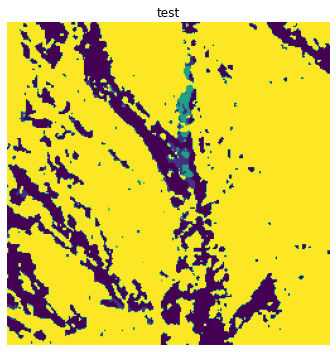

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(label)
ax.set_title(f"test")
ax.axis(False)
plt.tight_layout()

plt.show()

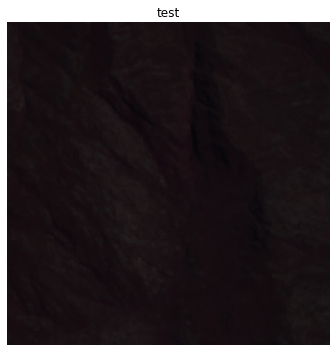

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"test")
ax.axis(False)
plt.tight_layout()

plt.show()